## Demo PyHeat Youri & Mathis

Ceci est une notebook de démo pour la lib pyheat.
C'est une version temporaire

Toutes les valeurs utilisées dans ce notebook sont totalement arbitraires.
L'objectif n'est pas de montrer des résultats mais le fonctionnement de la lib et ses entrées/sorties.

In [1]:
import numba
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
PARAM_LIST = (
    "moinslog10K",
    "n",
    "lambda_s",
    "rhos_cs"
)

In [2]:
from datetime import datetime

times = [datetime.fromtimestamp(1000*k) for k in range(500)]
temps = np.load("data/val_data.npy")

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.15, .25, .4], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .05,
    "dH_measures": list(zip(times,list(zip(-.01*np.cos(np.linspace(0,2*np.pi,500))+.03, temps[:,0])))),
	"T_measures": list(zip(times, temps[:,[32,66,-1]])),
    "sigma_meas_P": None, #float
    "sigma_meas_T": None, #float
}

col = Column.from_dict(col_dict)

In [3]:
try:
    col.get_depths_solve()
except ComputationOrderException as e:
    print(e)
    
try:
    col.get_all_n()
except ComputationOrderException as e:
    print(e)

compute_solve_transi has to be computed before calling get_depths_solve.
compute_mcmc has to be computed before calling get_all_n.


In [4]:
#Peut définir un tuple avec la class Param (NamedTuple)
params = Param(
    moinslog10K = 4,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6,
)

#Ou en tuple plus classiquement
params_tuple = (4, .1, 2, 4e6)

assert params == params_tuple

In [5]:
col.compute_solve_transi(params, 100)

temps = col.temps_solve

col.compute_solve_transi(params_tuple, 100)

temps_from_tuple = col.temps_solve

assert np.array_equal(temps, temps_from_tuple)

--- Compute Solve Transi ---
One layer : moinslog10K = 4, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.
--- Compute Solve Transi ---
One layer : moinslog10K = 4, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.


283.32455

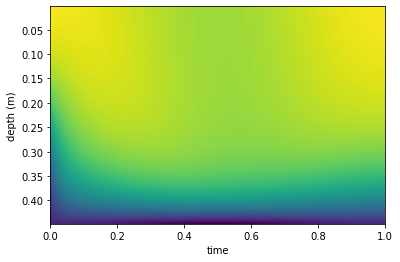

In [6]:
#Tout est stocké dans la class col pour ne pas avoir à le stocker hors de la class
fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [0, 1, col.depths_solve[-1], col.depths_solve[0]], #TODO : trouver comment monter le datetime
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
np.nanmin(col.temps_solve[:,:-5])

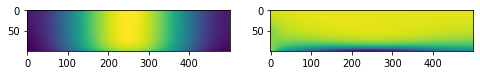

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8,8), facecolor = 'w')
axs[0].imshow(col.advec_flows_solve)
axs[1].imshow(col.conduc_flows_solve)

Text(0, 0.5, 'temperature (K)')

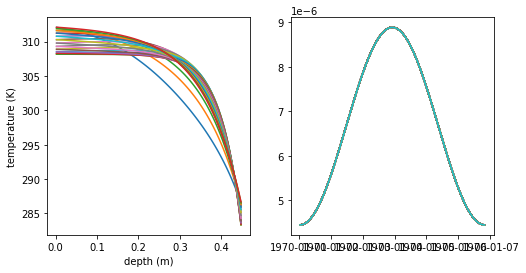

In [8]:
from itertools import islice

fig, axs = plt.subplots(1, 2, figsize=(8,4),facecolor = 'w')

ite = zip(
    col.temps_solve.T,
    col.times_solve
)
for temps, t in islice(ite, 20, None, 20):
    axs[0].plot(
        col.depths_solve,
        temps,
        label = f"{t:.1e}"
    )
axs[1].plot(
    col.times_solve,
    col.flows_solve.T,
    label = f"{t:.1e}"
)

axs[0].set_xlabel("depth (m)")
axs[0].set_ylabel("temperature (K)")
#axs[1].legend()

Index 23 in z_array -> 0.10575000000000001
Temp at index 23 and t = 0 -> 312.048
Temp at 0.106 -> 310.446
col.get_temps correct inaccuracy in z.
Temp at 0.107 -> 310.446


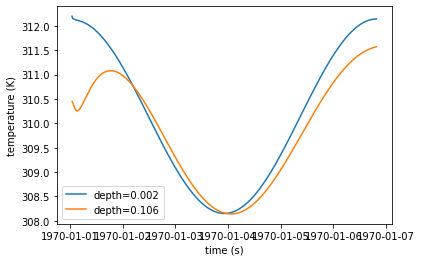

In [9]:
ind = 23
print(f"Index {ind} in z_array -> {col.depths_solve[ind]}")
print(f"Temp at index {ind} and t = 0 -> {col.temps_solve[0, ind]:.3f}")
print(f"Temp at {col.depths_solve[ind]:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind])[0]:.3f}")
print("col.get_temps correct inaccuracy in z.")
print(f"Temp at {col.depths_solve[ind]+1e-3:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind]+1e-4)[0]:.3f}")

fig, ax = plt.subplots(facecolor = 'w')
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[0]), label = f"depth={col.depths_solve[0]:.3f}")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind]), label = f"depth={col.depths_solve[ind]:.3f}")
ax.set_xlabel("time (s)")
ax.set_ylabel("temperature (K)")
ax.legend()
#TODO : Faire la meme avec le temps en paramètre

In [10]:
priors = {
    "moinslog10K": ((1.5, 6), .01), # (intervalle, sigma)
    "n": ((.01, .25), .01),
    "lambda_s": ((1, 5), .1),
    "rhos_cs": ((1e6,1e7), 1e5)
}

all_priors = [['couche1', 0.2,
            [Prior(*args) for args in (priors[lbl]
                                       for lbl in PARAM_LIST)]],
            ['couche2', 0.45,
            [Prior(*args) for args in (priors[lbl]
                                       for lbl in PARAM_LIST)]
        ]
        ]

sigma_prior = Prior((0, np.inf), 0.02, lambda x : 1/x)

col.compute_mcmc(
    nb_iter = 2000,
    all_priors = all_priors,
    nb_cells = 100,
    quantile = (.05, .5, .95),
    sigma_temp_prior = sigma_prior,
    incertitudes = False
)

--- Compute Mcmc ---
Priors :
    [Prior sur une valeure qui évolue entre 1.5 et 6, Prior sur une valeure qui évolue entre 0.01 et 0.25, Prior sur une valeure qui évolue entre 1 et 5, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
    [Prior sur une valeure qui évolue entre 1.5 et 6, Prior sur une valeure qui évolue entre 0.01 et 0.25, Prior sur une valeure qui évolue entre 1 et 5, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
Number of cells : 100
Number of iterations : 2000
Launch Mcmc
Mcmc Computation : 100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 128.76it/s]
Mcmc Done.
 Start quantiles computation
Quantiles Done.


Normal si les resultats ont pas de sens


AttributeError: 'State' object has no attribute 'params'

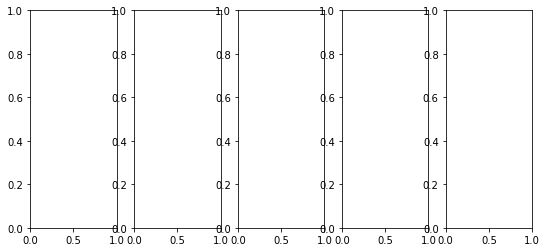

In [11]:
print("Normal si les resultats ont pas de sens")

fig, axes = plt.subplots(1, 5, figsize = (9,4), facecolor = 'w')

ite = zip(
    ["moinslog10K", "n", "lambda_s", "rhos_cs", "sigma_temp"],
    [col.all_moinslog10K, col.all_n, col.all_lambda_s, col.all_rhos_cs, col.all_sigma] 
)

for (lbl, vals), ax in zip(ite, axes):
    ax.hist(vals, bins = 20)
    ax.set_title(lbl)
#col.get_all_n() et ses dérivés sont aussi dispo sous forme de méthodes

Text(0, 0.5, 'acceptance')

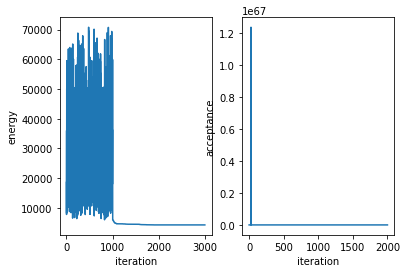

In [12]:
fig, axs = plt.subplots(1,2,facecolor = 'w')
axs[0].plot(col.all_energy)
axs[1].plot(col.all_acceptance_ratio)

axs[0].set_xlabel("iteration")
axs[0].set_ylabel("energy")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("acceptance")

In [13]:
#Can also sample param from mcmc trajectory
sampled_params = col.get_best_param()
print(sampled_params)

col.compute_solve_transi(sampled_params, 41)

fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [col.depths_solve[0], col.depths_solve[-1], 0, 1]
)

ax.set_xlabel("depth (m)")
ax.set_ylabel("time (s)")

AttributeError: 'State' object has no attribute 'params'

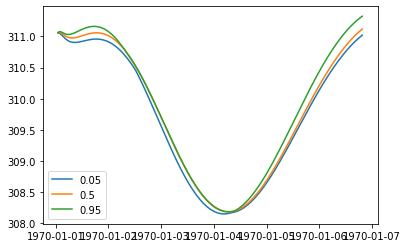

In [14]:
fig, ax = plt.subplots(facecolor = 'w')

#Pas encore possible de donner le temps encore.
for quant in (.05,.5,.95):
    ax.plot(
        col.times_mcmc,
        col.get_temps_quantile(quant)[20, :],
        label = quant
    )
    
ax.legend()

(array([  16.,   92.,   57.,   83.,  117.,  220.,   71.,   69.,   45.,
        1231.]),
 array([0.93128858, 0.94640222, 0.96151585, 0.97662948, 0.99174312,
        1.00685675, 1.02197039, 1.03708402, 1.05219766, 1.06731129,
        1.08242492]),
 <BarContainer object of 10 artists>)

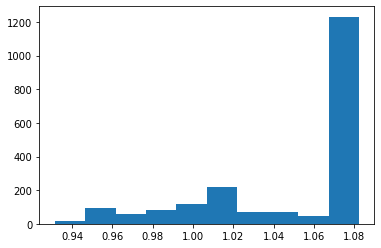

In [15]:
plt.hist(col.all_sigma)


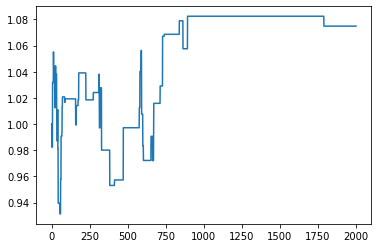

In [21]:
plt.plot(np.arange(2001),col.all_sigma)

In [17]:
np.size(np.zeros((11,10)))

110

In [18]:
plt.hist( [layer.params.n  for layer in (state.layers for state in col._states)]

SyntaxError: unexpected EOF while parsing (1630238256.py, line 1)